In [1]:
import numpy as np
from fastai import *
from fastai.data.all import *
from torchvision.models import * 
from fastai.vision.all import *
from fastai.vision.core import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = Path('./data')

In [3]:
imgs, lbl_bbox = get_annotations('./train.json')
img2bbox = dict(zip(imgs, lbl_bbox))

first = {k: img2bbox[k] for k in list(img2bbox)[1:2]}; first


{'salmon_20201006_PSCSal_4_Reach2-1_30m_12_T.jpg': ([[44, 1095, 62, 1185],
   [255, 1165, 305, 1208],
   [407, 1032, 428, 1118],
   [553, 566, 573, 642],
   [565, 609, 580, 683],
   [732, 506, 772, 545],
   [502, 203, 523, 252]],
  ['s', 's', 's', 's', 's', 's', 's'])}

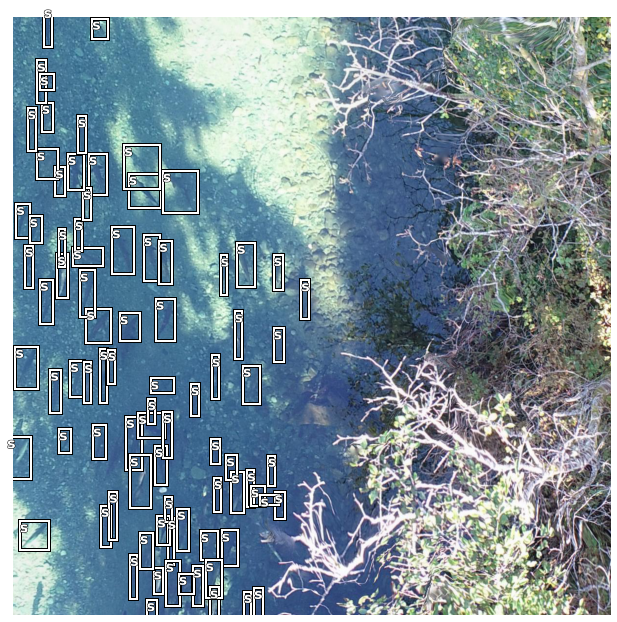

In [4]:
idx=5
fn,bbox = path/'train'/imgs[idx],lbl_bbox[idx]; fn
timg = Transform(PILImage.create)
img = timg(fn)
tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
ctx = img.show(figsize=(11,11))
tbbox.show(ctx=ctx);

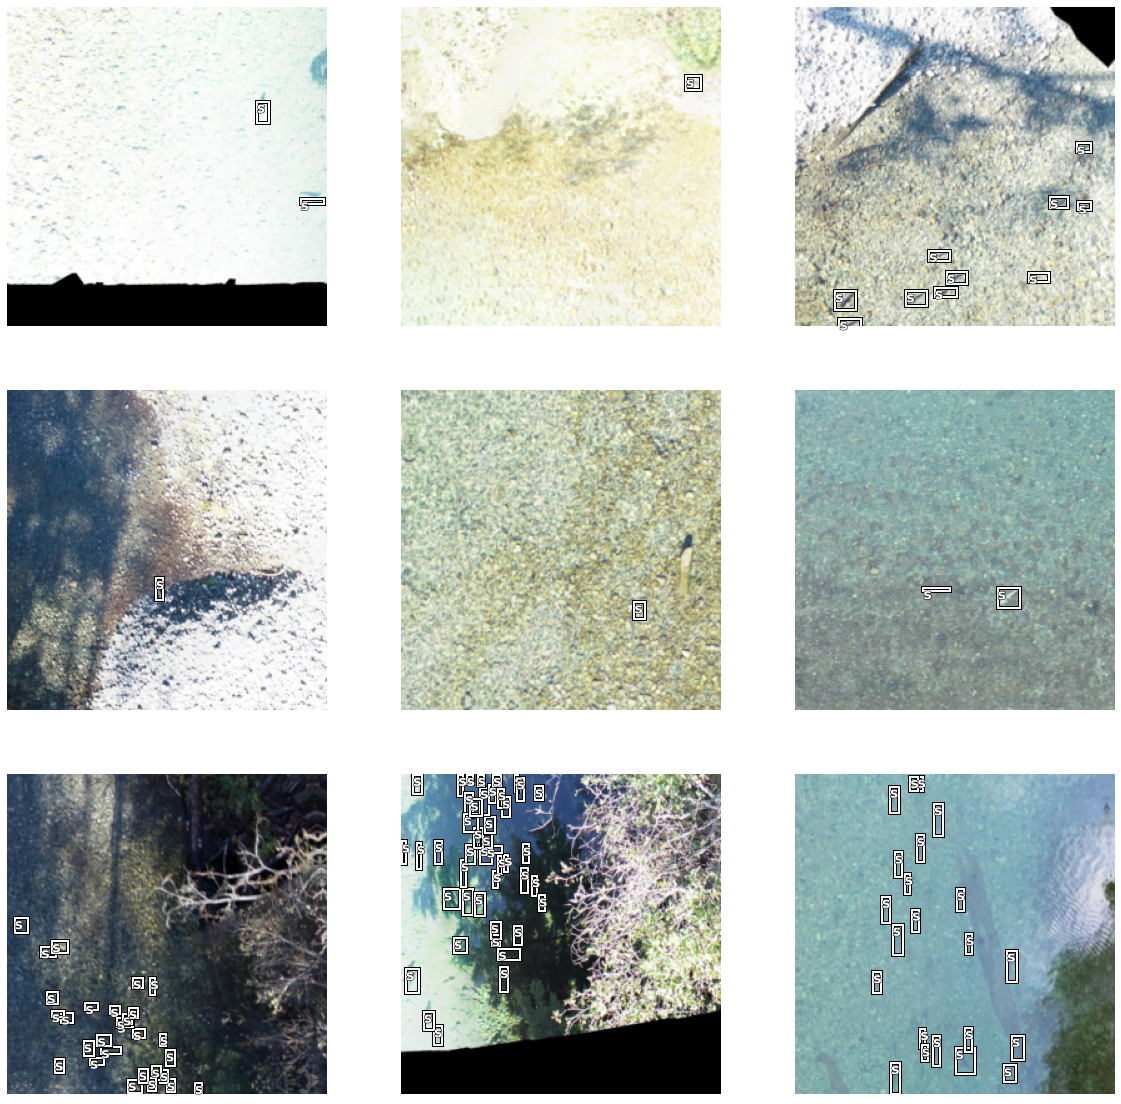

In [5]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

item_tfms = [Resize(256, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

def get_train_imgs(noop):  return imgs

salmon = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)
                 
dls = salmon.dataloaders(path/'train')
dls.c = 5
dls.show_batch(figsize=(20,20))

In [6]:
from wwf.vision.object_detection import *
encoder = create_body(resnet34, pretrained=True)
get_c(dls)

arch = RetinaNet(encoder, get_c(dls), final_bias=-4)
create_head(124, 4)
arch.smoothers
arch.classifier
arch.box_regressor

ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

learn.freeze()

In [7]:
learn.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 3.95 GiB total capacity; 2.65 GiB already allocated; 247.44 MiB free; 2.71 GiB reserved in total by PyTorch)